In [1]:
import glob
import os
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
import torchvision
import cv2


In [2]:
phone_num_dataset = pd.read_csv("data\phone_numbers_dataset.csv")

id = 1
image_name = phone_num_dataset.iloc[id, 0]
phone_number = str(phone_num_dataset.iloc[id, 1])

print('Image name: ', image_name)
print('Phone number: ',phone_number)

Image name:  phoneNumberImage1.png
Phone number:  529750676


In [3]:
display(phone_num_dataset.head())

,image_id,phone_number
0,phoneNumberImage0.png,6420513217
1,phoneNumberImage1.png,529750676
2,phoneNumberImage2.png,1129451587
3,phoneNumberImage3.png,1889324881
4,phoneNumberImage4.png,8296078985


In [4]:
print("Number of Images in dataset: ", phone_num_dataset.shape[0])

Number of Images in dataset:  40000


## Look at some images

In [5]:
def show_Image(image):
    plt.imshow(image, cmap='gray')

In [6]:
image_name = phone_num_dataset.loc[0, 'image_id']
print(image_name)

phoneNumberImage0.png


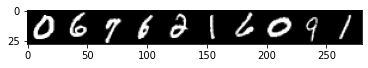

In [7]:
i = 10
image_name = phone_num_dataset.loc[i, 'image_id']
phone_number = str(phone_num_dataset.loc[i, 'phone_number'])
if(len(phone_number) != 10):
    s = '0' * (10 - len(phone_number))
    phone_number = s + phone_number
display_image = cv2.imread(os.path.join('data\phone_number_images\\', image_name))
show_Image(display_image)

In [8]:
print("Phone Number: ", phone_number)

Phone Number:  0676216091


# Dataset class and Transformations

In [9]:
from torch.utils.data import Dataset, DataLoader

class PhoneNumberDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.phone_numbers_frame = pd.read_csv(csv_file)
        self.trasform = transform
    def __len__(self):
        return len(self.phone_numbers_frame)
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.phone_numbers_frame.iloc[idx, 0])
        
        image = cv2.imread(image_name)
        if(image.shape[2] == 4):
            image = image[:, :, 0:3]
        
        phone_number = str(self.phone_numbers_frame.iloc[idx, 1])
        if(len(phone_number) != 10):
            s = '0' * (10 - len(phone_number))
            phone_number = s + phone_number
        sample = {'image' : image, 'phone_number' : phone_number}

        if self.trasform:
            sample = self.trasform(sample)

        return sample

In [10]:
Number_dataset = PhoneNumberDataset(csv_file="data\phone_numbers_dataset.csv",
root_dir='data\phone_number_images\\')

print('Length of dataset: ', len(Number_dataset))

Length of dataset:  40000


0 (28, 280, 3)
1 (28, 280, 3)
2 (28, 280, 3)


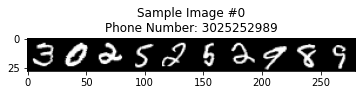

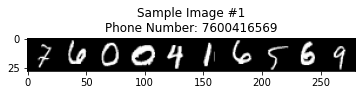

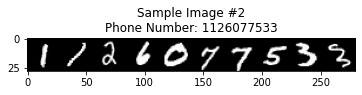

In [11]:
num_to_display = 3

for i in range(num_to_display):
    fig = plt.figure(figsize=(20, 10))
    rand_i = np.random.randint(0, len(Number_dataset))
    sample = Number_dataset[rand_i]
    phone_number = sample['phone_number']
    print(i, sample['image'].shape)
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title(f'Sample Image #{i}\nPhone Number: {phone_number}')
    show_Image(sample['image'])

# Transforms

In [12]:
import torch
from torchvision import transforms, utils

class Gray_scale_Image(object):
    def __call__(self, sample):
        image, phone_number = sample['image'], sample['phone_number']
        image_copy = np.copy(image)
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
        return {'image': image_copy, 'phone_number': phone_number}

class Normalize(object):
    def __call__(self, sample):
        grayScaleConverter = Gray_scale_Image()
        sample = grayScaleConverter(sample)
        image, phone_number = sample['image'], sample['phone_number']
        image_copy = np.copy(image)
        image_copy = image_copy / 255.0
        return {'image': image_copy, 'phone_number': phone_number}

class Gray_scale_to_Binary(object):
    def __call__(self, sample):
        if isinstance(sample, dict):
            image, phone_number = sample['image'], sample['phone_number']
            image_copy = np.copy(image)
            _, image_copy = cv2.threshold(image_copy, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            return {'image': image_copy, 'phone_number': phone_number}
        else:
            image_copy = np.copy(sample)
            _, image_copy = cv2.threshold(image_copy, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            return image_copy

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))
        return img

class Dilation(object):
    def __call__(self, image):
        image_copy = np.copy(image)
        kernel = np.ones((3,3), np.uint8)
        image_copy = cv2.dilate(image_copy, kernel, iterations=1)
        return image_copy

class MedianFilter(object):
    def __call__(self, sample):
        if isinstance(sample, dict):
            image, phone_number = sample['image'], sample['phone_number']
            image_copy = np.copy(image)
            image_copy = cv2.medianBlur(image_copy, 3)
            return {'image': image_copy, 'phone_number': phone_number}
        else:
            image_copy = np.copy(sample)
            image_copy = cv2.medianBlur(image_copy, 3)
            return image_copy

class Erosion(object):
    def __call__(self, image):
        image_copy = np.copy(image)
        kernel = np.ones((3,3), np.uint8)
        image_copy = cv2.erode(image_copy, kernel, iterations=1)
        return image_copy

class BoundingBoxes(object):
    def __call__(self, sample):
        image, phone_number = sample['image'], sample['phone_number']
        rescale = Rescale((28, 28))
        image_copy = np.copy(image)
        contours, heirarchy = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        contours_poly = [None] * len(contours)
        bound_rect = []

        for i, c in enumerate(contours):
            if heirarchy[0][i][3] == -1:
                contours_poly[i] = cv2.approxPolyDP(c, 3, True)
                bound_rect.append(cv2.boundingRect(contours_poly[i]))

        bound_rect.sort(key=lambda x: -x[2] * x[3])
        bound_rect = bound_rect[0:10]
        bound_rect.sort(key=lambda x : x[0])

        image_list_digits = []
        digits_list = []

        i = 0
        for box in bound_rect:
            x, y, h, w = box
            if(x > 1 and y > 1):
                imgTemp = rescale(image_copy[int(y - 1) : int(y + w + 1), int(x - 1) : int(x + h + 1)])
            elif(x > 2 and y > 2):
                imgTemp = rescale(image_copy[int(y - 2) : int(y + w + 2), int(x - 2) : int(x + h + 2)])
            else:
                imgTemp = rescale(image_copy[int(y) : int(y + w), int(x) : int(x + h)])
            image_list_digits.append(imgTemp)
            digits_list.append(int(phone_number[i]))
            i+=1
            
        image_list_digits = np.array(image_list_digits)

        for i in range(10):
            sample_Temp = image_list_digits[i]
            for j, fx in enumerate([MedianFilter(), Rescale((28, 28)), Gray_scale_to_Binary()]):
                transformed_img = fx(sample_Temp)
                sample_Temp = transformed_img
            image_list_digits[i] = sample_Temp
                

        return {'digit_Images_list': image_list_digits, 'digits_list': digits_list}

class ToTensor(object):
    def __call__(self, sample):
        digit_Images_list, digits_list = sample['digit_Images_list'], sample['digits_list']
        image_copy = np.copy(digit_Images_list)
        # image_copy = image_copy.transpose((2, 0, 1))
        return{'image': torch.from_numpy(image_copy), 'digits_list': digits_list}

# Test out the transforms

10


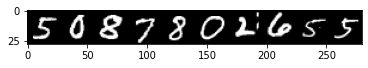

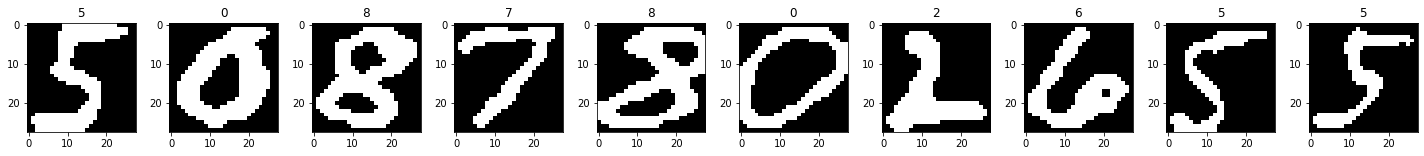

In [13]:
composed = transforms.Compose([Gray_scale_Image(), Gray_scale_to_Binary(), BoundingBoxes()])

test_num = 550
sample = Number_dataset[test_num]
show_Image(sample['image'])
transformed_sample = composed(sample)
digit_image_list = transformed_sample['digit_Images_list']
digit_list = transformed_sample['digits_list']
print(len(digit_image_list))
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(digit_image_list):
    ax = plt.subplot(1, 10, i + 1)
    plt.tight_layout()
    ax.set_title(digit_list[i])
    show_Image(digit_image_list[i])
plt.show()


## Create the trandsformed dataset

In [14]:
data_transform = transforms.Compose([Gray_scale_Image(), Gray_scale_to_Binary(), BoundingBoxes(), ToTensor()])
transformed_Number_dataset = PhoneNumberDataset(csv_file='data\phone_numbers_dataset.csv',
                                                root_dir='data\phone_number_images\\',
                                                transform=data_transform)


In [15]:
print('Number of images: ', len(transformed_Number_dataset))
for i in range(5):
    sample = transformed_Number_dataset[i]
    print(i, sample['image'].size())

Number of images:  40000
0 torch.Size([10, 28, 28])
1 torch.Size([10, 28, 28])
2 torch.Size([10, 28, 28])
3 torch.Size([10, 28, 28])
4 torch.Size([10, 28, 28])


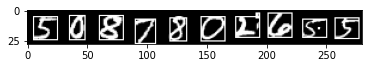

In [16]:
gray = Gray_scale_Image()
def bounding_boxes(img):
    contours, heirarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    contours_poly = [None] * len(contours)
    bound_rect = []

    for i, c in enumerate(contours):
        if heirarchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            bound_rect.append(cv2.boundingRect(contours_poly[i]))

    for i in range(len(bound_rect)):
        color = (255, 0)
        cv2.rectangle(img, (int(bound_rect[i][0]), int(bound_rect[i][1])), 
              (int(bound_rect[i][0] + bound_rect[i][2]), int(bound_rect[i][1] + bound_rect[i][3])), color, 1)
    return img, bound_rect

sample = Number_dataset[550]
sample = gray(sample)
img1 = sample['image']
img1, _ = bounding_boxes(img1)
plt.imshow(img1, cmap='gray')
plt.show()